Hello! Here is some documented sample code that is executable (simply hit `shift enter` in each code cell to run its contents).


# Stochastic charging algorithm for nanodust in planetary rings

## Brief rationale and background for the charging method
A nanograin’s charge varies stochastically with time: in each timestep the number of electrons/ions collected by the grain must be estimated according to the appropriate probabilities. The key currents of interest for dust in Saturn's rings are summarised in the figure below:

<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/summary_currents_schematic.png width="350">

Instead of modelling the inter-arrival times of plasma particles using an exponential distribution (cf. [Cui & Goree
(1994)](https://doi.org/10.1109/27.279018) ), the Poisson distribution can be used to model the number of charged particles being collected by the grain in a given timestep. The type of particle is handled by the algorithm as described below, involving Poisson and binomial probability distributions and weighting the various currents according to their relative strengths.

## Theory
[Hsu et al. (2011)](https://doi.org/10.1029/2011JA016488) introduce a Poisson process approach, which is further developed in
the work of [Hsu et al. (2018)](https://doi.org/10.1126/science.aat3185). They developed their procedure independently of [Cui & Goree
(1994)](https://doi.org/10.1109/27.279018) but reach a similar approach. Their method can be summarised as 
    
    - Generate a random number to determine how many events occur during the timestep using a Poisson probability distribution
    - Decide the type of charging event that occurs according to the relative strengths of the various currents.


For the plasma and photoemission currents ($I_i, I_e, I_\nu$) considered here, the expected number of charging events occurring between a time $t_n$ and $t_n + h$ (i.e. the rate, $\lambda_\alpha$) for a current of type $\alpha$ is
 
 \begin{equation}
 \lambda_\alpha = \int_{t_n}^{t_n + h} \frac{I_\alpha}{e} dt \quad \mathrm{for }\enspace \alpha=i, e, \nu,
 \label{eqn:lambdaAlpha}
 \end{equation}
 
 where the plasma ion ($i$), plasma electron ($e$), and photoelectron emission ($\nu$) currents are known expressions (for the purposes of this notebook, they are not of importance, but a fuller description can be found in my thesis).
 
 A random number is generated from a uniform distribution, $R_\textrm{P}^\alpha \sim U[0,1)$ and compared to the Poisson distribution for each current type,
 
 \begin{equation}
 P(\lambda_\alpha, k_\alpha) = \text{exp}(-\lambda_\alpha)\frac{\lambda_\alpha ^{k_\alpha}}{k_\alpha!}, \text{for } k_\alpha = 0,1,\ldots 
 \end{equation}

given a number of charging events $k_\alpha = 0,1,\ldots$.  

So, for example, if $\lambda_\alpha = 0.4$ for a given current type (assuming a single current for simplicity) and the random number happens to be $R_\textrm{P}^\alpha=0.965$, then comparing to the corresponding probabilities:

 \begin{align}
 P(\lambda_\alpha &= 0.4, k_\alpha = 0) = 0.670\ldots,  \nonumber\\[-10pt]
 P(\lambda_\alpha &= 0.4, k_\alpha = 1) = 0.268\ldots, \nonumber\\[-10pt]
  P(\lambda_\alpha &= 0.4, k_\alpha = 2) = 0.0536\ldots, \nonumber \\[-10pt]
    P(\lambda_\alpha &= 0.4, k_\alpha = 3) = 0.00715\ldots, \label{eqn:PoissEG} \\[-10pt]
    \ldots \nonumber
 \end{align}
 
 which are illustrated in the figure below:
 
<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/eg_numberline_poisson.png width="800"> 
 
where it can  be seen that the $k_\alpha=2$ event is chosen as $R_\textrm{P}^\alpha$ falls within that bin; that is, two charges happen to be collected by the grain during that timestep. The nature of the charges, whether electron or ion, depends on the current type in question; the way that the code developed here handles multiple current types is explained in greater detail below.

[Hsu et al. (2011)](https://doi.org/10.1029/2011JA016488) sets an upper bound on the expected number of charging events in a given time interval,  $\lambda_{\alpha} \sim 0.4$ so that the probability of having more than one charging event per step is $1 - P(k_\alpha=0,1) = \mathrm{e}^{-0.4} (1+0.4) \approx 6.2 \%$. That is, they choose their timestep sizes so that no more than a single charging event takes place during each step in most cases. The exact time of the charging event is unknown (beyond the resolution of the step size chosen by the orbital integrator), and therefore allowing more than one charging event per step would enhance this inaccuracy because it would permit several charging events to occur simultaneously at the start of a (single larger) step. The charging timescale should determine the modelling timestep used in the numerical integration.
 
 The method of [Hsu et al. (2011)](https://doi.org/10.1029/2011JA016488) either permits the occasional multiple charging event to occur in a single step or discards steps with $\lambda_{\alpha} > 0.4$, which has the potential to skew the probability distribution towards prohibiting rare multiple events. In this work, a timestep-splitting approach is taken to *ensure* that no more than a single charging event occurs within a single (sub)step, by recursively splitting the step until that condition is fulfilled.  This novel stochastic charging method automates the process of simultaneously updating the equations of motion and charging equation, $\frac{dq_d}{dt} = \sum_{\alpha} I_\alpha$,  by utilising a binary tree traversal algorithm. 



## Binary tree traversal

If the adaptive integrator for the equations of motion returns a timestep during which the total number of charging events for all the currents is greater than one, $\sum\limits_{\alpha} k_\alpha > 1$, then the timestep is divided in half and the charging events are distributed across the step according to binomial probability distributions, weighted according to the respective strengths of the contributing currents,  which will be explained further in the following examples. It is helpful to describe a specific single current case before generalising.
 

### Single current

The decision of how to distribute the multiple charging events for a single current in time across the step is a matter of finding the random variable $X_\alpha$, denoting the number of electrons/ions collected by the grain for the first half-step (as the number of charging events in the second half-step must be the difference between the number of charging events for the full step and the first half-step: $k_\alpha - X_\alpha$). The number of charging events for the first half-step, $x_\alpha$, is obtained from the binomial distribution, as it can  be modelled as the probability of obtaining $X_\alpha$ events in the first half-step out of $k_\alpha$ Bernoulli trials:
 
 \begin{equation}
% P(X_\alpha = x_\alpha) =  {}^{k_\alpha}C _{x_\alpha} \left(\frac{1}{2}\right)^{k_\alpha} \mathrm{for } \enspace  x_\alpha = 0, 1, \dots , k_\alpha,
%P(X_\alpha = x_\alpha) =  \frac{k_\alpha !}{x_\alpha!(k_\alpha - x_\alpha)!} \left(\frac{1}{2}\right)^{x_\alpha}\left(\frac{1}{2}\right)^{k_\alpha - x_\alpha}  \mathrm{for } \enspace  x_\alpha = 0, 1, \ldots , k_\alpha,
P(X_\alpha = x_\alpha) =  \frac{k_\alpha !}{x_\alpha!(k_\alpha - x_\alpha)!} \left(\frac{1}{2}\right)^{k_\alpha} \mathrm{for } \enspace  x_\alpha = 0, 1, \ldots , k_\alpha,
\label{eqn:BinomProb}
 \end{equation}  
 
noting the assumption that any electron/ion is equally likely to encounter the dust grain in the first or second sub-step, hence a probability of $\frac{1}{2}$ above. 

Consider the simple case of a single current $I_\alpha$, once a random number, $R^\alpha_1 \sim U(0,1]$ has been generated and compared to the Poisson distribution, which causes say two electrons/ions to collect on the grain, $k_\alpha = 2$. Since only one or zero charging events are permitted per timestep, the step is split in half, and the order in which the two events occur over time is generated using a binomial distribution with a second random number, $R_\textrm{B} \sim U(0,1]$:


<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/eg_numberline_binomial.png width="800">

If $R_\textrm{B}$ = 0.7641, for example, then both charging events occur in the first half-step (see numberline above), which will need to be further split again, and the zero events in the second half-step stored. 

The recursive nature of the problem of assigning charging events between substeps lends itself well to using binary trees, hierarchical data structures consisting of nodes and edges. The root node contains the initial timestep's charging event number, $k_\alpha > 1$, then the left and right branches are populated at each level as the (sub)steps are split in half recursively and charging events assigned to each based on binomial probabilities, until the base case of $k_{\alpha} = \{0,1\}$ is achieved,  thereby terminating the tree structure at leaf nodes. The arrow of time means that the code must execute a *pre-order tree traversal* (a variant of depth first traversal), so that the nodes are visited in the correct order and the timestep is incremented from leftmost leaf node to rightmost leaf node. The code abstracts the binary tree away and uses a tree walker function to track the level of the node and randomly generate the children of the current node it is located at, thereby adding a *left branch* and *right branch* frame object to the top of the call stack; then when the leaf node is reached, each walker function call is returned and a frame object is popped off the call stack. 

### Single current example

That's enough theory! Here's some code. 

**TL;DR**: The following snippet assumes $k = 3$ has been generated from the Poisson distribution for a single charging current. The aim is to work out how those 3 charging events are distributed in time across the step. The random numbers, `R`, in the following code cell have actually been set to specific values to check that the recursive tree walker behaves as expected (comparing to pen and paper calculations):

In [ ]:
# Single current with R set at each level for checking purposes (rather than allowing randomness) 

import numpy as np
from scipy.stats import binom
from binarytree import Node # see https://pypi.org/project/binarytree/ and https://github.com/joowani/binarytree/blob/master/binarytree/__init__.py

def binomial_prob(N,R):
    """
    Works out how to resolve k>1 charging events in time across step
    Inputs: 
        N = Number of charging events generated from Poisson distribution for full timestep
        R = Random number drawn from uniform probability distribution U(0,1] to compare to the binomial probabilities
    """
    # Use the drawn uniform number to see how the charging events are split between the parent's 2 child sub-steps
    #R = np.random.uniform(low=0.0, high=1.0) # draw a random number from Uniform probability distribution
    print("binomial_prob R = ", R, "N = ", N)
    
    # Check where R falls in the Binomial probability distribution
    start_pt = 0.0 # define a variable to store the start point of probability distribution range
    k_ctr = 0
    end_pt = binom.pmf(k=k_ctr, n=N, p=0.5) # Define the end point for the first partition (for X = 0) using prob mass function to calculate binomial probability for k=0
    
    #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, 
    # so that unnecessary calculations are avoided
    while ((R >= end_pt) and (k_ctr < N)): 
        k_ctr+=1 #increment to the next prob range
        start_pt = end_pt # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
        end_pt += binom.pmf(k=k_ctr, n=N , p=0.5)

    print("R lies in bin where k = ", k_ctr)
    return k_ctr

def walker(value, level=0, tree=Node(0)): 
    """
    Binary tree walker. Recursively splits timestep in half and keeps track of which level it is on, until the base case of k = 0 or 1 is reached.
    Inputs:
        value = number of charging events at a particular tree level
        level = depth of tree 
        tree = object to be printed for visual check
    """
    
    # Print test (rather than allowing R to be random, force R so can check get the expected output)
    if level == 0:
        R = 0.548
    elif level == 1:
        R = 0.967
    elif level == 2:
        R = 0.873
    elif level == 3:
        R = 0.154
    elif level == 4:
        R = 0.223
    elif level == 5:
        R = 0.588
    else:
        R = 999999999999999999999 # Use redonkulus value so easily flagged if bug, I need to assign a UNUSED value to R, otherwise Python complains about R being referenced before assignment
    
    # Use binomial prob to determine how the number of charging events are split across 1st and 2nd half of step
    substep1 = binomial_prob(value, R) 
    substep2 = value - substep1 # The second substep is set by the first substep (number of charging events is conserved)

    # Define the left and child nodes:
    tree.left = Node(substep1)
    tree.right = Node(substep2)
    
    if value == 1 or value == 0: # base case (leaf nodes have no children)
        print("Base case")
        tree.left = None 
        tree.right = None
        return [(value, level)], tree # store the base leaf node value (ie k=0 or k=1) and its corresponding level as tuple-element of list
    
    a, tree_l = walker(substep1, level+1, tree.left) # recursive call to left child
    b, tree_r = walker(substep2, level+1, tree.right) # recursive call to right child
    
    print(f"walker level{level} called with value {value} splits into {substep1} and {substep2} as R = {R}")
    print(f" a = {a}, b = {b}")
    # Reconfigure the binary tree to update:
    tree.left = tree_l
    tree.right = tree_r
    return a + b, tree #concatenate list (a+b) and also return tree

N_init = 3
lev = 0
leaf_nodes,tree = walker(N_init, level=lev, tree=Node(N_init))

print("Result: ", leaf_nodes) # leaf_nodes lists tuples of (value, level) ie it lists tuples of (num_of_charging_event, l-index of 1/2^l substep)
print(tree)

# Use the results from the tree_walker to traverse a (toy dummy) step:
delta_t = 1.0 # some arbitrary initial timestep size
t = 0.0 # dummy time variable 
Q = 0.0 # dummy charge variable
t_arr = [t]
Q_arr = [Q]
    
for (Q_sub, level) in leaf_nodes:
    print(f"Charging event of {Q_sub} at level {level}")
    t = t + delta_t/(2**level)
    Q = Q + Q_sub
    t_arr.append(t)
    Q_arr.append(Q)

print(f"Traversing step results, t = {t_arr }; Q = {Q_arr}")

The depth of the leaf node $l$ enables the timestep to be traversed in increments of $\frac{h}{2^l}$, for example:

<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/binarytree_kalpha_7.png width="500">

### Multiple current example

The approach can be generalised for multiple current types to account for the photoelectron current and plasma electron and ion currents simultaneously. The expected number of charging events, $\lambda_\alpha$, is calculated for each current respectively. Together with the Poisson distribution and a uniform random number for each current, $R_\textrm{P}^\alpha\sim [0,1)$, this generates the number of charging events in a given timestep for each current, $k_\alpha$. If $\sum_\alpha k_\alpha > 1$, then the step must be split and the events distributed in smaller substeps using a similar approach to that used for a single current. However, given that there are multiple currents to consider, the binomial probability distributions for each type of current must be weighted according to the fraction of events that each contributes,

\begin{equation}
W_\alpha = \frac{k_\alpha}{\sum_\alpha k_\alpha}.
\label{eqn:BinomWeight}
\end{equation}


A resulting binary tree structure for multiple current types with the Poisson-generated events $k_e =2, k_i=4,  k_\nu = 0$ is sketched out below:

<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/eg_numberline_weightedbinomial.png  width="800"> 

<img src=https://raw.githubusercontent.com/MJTMace/testsample/main/imgs/binarytree_ke_2_ki_4.png  width="500"> 

Another example ($k_e= 3, k_i = 2, k_\nu=0$) is illustrated in code below (checking output to pen and paper calculations by forcing `R` values): 

In [ ]:
#Stand-alone tree walking program (to traverse the binary tree)
# Multiple current with R set at each level for checking purposes (rather than allowing randomness) 
# k_e= 3, k_i = 2, k_\nu=0

import numpy as np
from scipy.stats import binom
from binarytree import Node # see https://pypi.org/project/binarytree/ and https://github.com/joowani/binarytree/blob/master/binarytree/__init__.py

def nodify(k):
    """
    Format charging events so can be printed nicely with binarytree's Node function
    """
    # Use a function to sort out the string concatenating and then transforming into a float
    # Node method cannot handle non-numbers so I need to hack a way to display the plasma electron, plasma ion, and photoelectron event numbers at each level
    # k = [k_e, k_i, k_nu]
    return float(str(k[0]) + "." + str(k[1]) + str(k[2]) ) # note that if k_e=1, k_i=2, k_nu = 0 then it will read as "1.2" rather than "1.20"


def binomial_prob_multiI(k_arr, R):
    """
    Works out how to resolve k>1 charging events in time across step
    Inputs: 
        k_arr = Number of charging events generated from Poisson distributions for multiple current types for the full timestep
        R = Random number drawn from uniform probability distribution U[0,1] to compare to the binomial probabilities
    """
        
    # Multiple currents
    # Use the drawn uniform number to see how the charging events are split between the parent's 2 child sub-steps
    # I need to unpack the total number of charging events from the list passed into this function:
    N_e = k_arr[0]
    N_i = k_arr[1]
    N_nu = k_arr[2]

    #print(f"N_e = {N_e}, N_i = {N_i}, N_nu = {N_nu}")
    if N_e == 0 and N_i == 0 and N_nu == 0:
        print("WARNING: all N_e and N_i and N_nu = 0 !!")
    elif N_e == 1 and N_i == 1 and N_nu == 1: # if there happens to be one electron and one ion charging event and one photoemission event, it should be equally probable to pick either of the 3
        #print("In special case [1,1,1]")
        k_ctr = [99999999999999, 99999999999999, 99999999999999] # Initialize variable: use redonkulus value that would get clearly flagged up if there's a bug  rather than NaN, otherwise Node() complains!
        if R <= (1.0/3.0):
            k_ctr[0] = 1; k_ctr[1] = 0; k_ctr[2] = 0
        elif (1.0/3.0) < R <= (2.0/3.0):
            k_ctr[0] = 0; k_ctr[1] = 1; k_ctr[2] = 0
        else: # if R lies between 2/3 and 1
            k_ctr[0] = 0; k_ctr[1] = 0; k_ctr[2] = 1
    else:
        #print(f"In else clause, R = {R}")
        #R = np.random.uniform(low=0.0, high=1.0) # draw a random number from Uniform probability distribution
        #print("binomial_prob R = ", R, "N = ", N)
        # Initialise 2-element array to store result for [I_e, I_i] number of charging events
        k_ctr=[99999999999999, 99999999999999, 99999999999999] # use an integer value that would get clearly flagged up if there's a bug in my code
        
        # Check where R falls in the weighted nested Binomial probability distribution
        # Note that because there is more than one type of current, I need to concurrently work out the respective probabilities for each type
        # Therefore I need to define separate counters k_e_ctr, k_i_ctr, k_nu_ctr
        
        ##First define plasma electron current probability variables
        start_pt_e = 0.0 # define a variable to store the start point of probability distribution range for I_e
        k_e_ctr = 0
        # Define the end point for the first partition (for X_e = 0) using prob mass function to calculate binomial probability for k_e=0, making sure to weight it appropriately
        end_pt_e = (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e, p=0.5)
        
        #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
        # Bug fix: if there happens to be one electron charging event and R falls inside of the k_e events bin then R must fall inside the k_e=1 event prob range
        # First check whether it's an I_e type event:
        if N_e == 1 and R < end_pt_e: 
            k_ctr[0]=1; k_ctr[1]=0; k_ctr[2]=0
            return(k_ctr)
            
        while ((R >= end_pt_e) and (k_e_ctr < N_e)):
            k_e_ctr+=1 #increment to the next prob range
            start_pt_e = end_pt_e # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
            end_pt_e += (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

        # Store the number of I_e charging events as the 0th element in the list of k events:
        k_ctr[0] = k_e_ctr # note that if R doesn't lie within the I_e weighted range, then k_e_ctr is erroneously set to be N_e but it gets corrected below
        k_ctr[1] = 0 # If an electron event has been chosen then the ion event must be zero
        k_ctr[2] = 0 # If an electron event has been chosen then the photoelectron event must be zero
        
        # Then check whether it's an I_i type event (only do this if R has not been found to lie inside I_e probability ranges)
        if R > end_pt_e: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges
            #print("In if R > end_pt_e ")
            k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
            k_ctr[2] = 0 # also ensure that the photoelectron event is zero in the case of an ion event
                        
            # To save memory, only initialise variables if they are actually going to be used!
            # Define a variable to store the start point of probability distribution range for I_i current
            start_pt_i = N_e/(N_e+N_i+N_nu) # this coincides with the end point of the I_e current
            k_i_ctr = 0
            # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
            end_pt_i = start_pt_i + (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i, p=0.5)
            
            # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
            if N_i == 1 and R < end_pt_i: 
                #print("In if N_i == 1")
                k_ctr[0]=0; k_ctr[1]=1; k_ctr[2]=0
                return(k_ctr)
            
            while ((R >= end_pt_i) and (k_i_ctr < N_i)):
                #print(f"In while ((R >= end_pt_i) and (k_i_ctr < N_i)) ")
                k_i_ctr+=1 #increment to the next prob range
                start_pt_i = end_pt_i # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                end_pt_i += (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
            # Store the number of I_i charging events as the 1st element in the list of k events:
            k_ctr[1] = k_i_ctr
            # Then check whether it's an I_nu type event (only do this if R has not been found to lie inside I_e or I_i probability ranges)
            if R > end_pt_i: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges (note the indentation)
                #print("In if R > end_pt_e ")
                k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
                k_ctr[1] = 0 # also ensure that the plasma ion current event is zero in the case of a photoelectron event
               
                # To save memory, only initialise variables if they are actually going to be used!
                # Define a variable to store the start point of probability distribution range for I_nu current
                start_pt_nu = (N_e+N_i)/(N_e+N_i+N_nu) # this coincides with the end point of the (I_e + I_i) currents
                k_nu_ctr = 0
                # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
                end_pt_nu = start_pt_nu + (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu, p=0.5)
                 # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
                if N_nu == 1 and R < end_pt_nu: 
                    k_ctr[0]=0; k_ctr[1]=0; k_ctr[2]=1
                    return(k_ctr)
                
                #print(f"k_ctr = {k_ctr}")
                #print(f"start_pt_nu = {start_pt_nu}, end_pt_nu = {end_pt_nu}")
                while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)):
                    #print(f"In while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)) ")
                    k_nu_ctr+=1 #increment to the next prob range
                    start_pt_nu = end_pt_nu # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                    end_pt_nu += (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

                # Store the number of I_i charging events as the 1st element in the list of k events:
                k_ctr[2] = k_nu_ctr
        
    return k_ctr

def walker(value_arr, level=0, tree=Node(0), level_1_switch=1): 
    """
    Binary tree walker. Recursively splits timestep in half and keeps track of which level it is on, until the base case of k = 0 or 1 is reached.
    Inputs:
        value = number of charging events at a particular tree level
        level = depth of tree 
        tree = object to be printed for visual check
        level_1_switch = switch to give deterministic output so results can be checked with theory
    """
        
    if ( (value_arr[0]==1 and value_arr[1]==0 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 1 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 0 and value_arr[2]==1) or
        (value_arr[0]==0 and value_arr[1]==0 and value_arr[2]==0)): # base case (leaf nodes have no children)
        #print("Base case")
        tree.left = None 
        tree.right = None
        return [(value_arr, level)], tree, level_1_switch # store the leaf node value (ie k=0 or k=1) and its corresponding level as tuple-element of list
    
    print(f"level_1_switch = {level_1_switch}")
    # Rather than allowing R to be random, force R so that can check get the expected output)
    if level == 0:
        R = 0.47
    elif level == 1 and level_1_switch ==0 :
        R = 0.3
        level_1_switch = 1
    elif level_1_switch == 1 and level_1_switch ==1:
        R = 0.45
        level_1_switch = 0
    elif level == 2 and level_1_switch==0:
        R = 0.92
    elif level == 3:
        R = 0.1
    elif level == 4:
        R = 0.67
    elif level_1_switch == 1: # in order to make the code enter the level == 1 subblock twice, flip the switch on
        R = 0.45    #  there needs to be a double split happening at level 1, i.e. k_e = 2 needs to split as does k_e=1, k_i=2
    else:
        R = 99999999999999 # I need to assign a UNUSED value to R, otherwise Python complains about R being referenced before assignment. Use redonkulus value easily flagged in case of bug
   
    # Use binomial prob to determine how the number of charging events are split across 1st and 2nd half of step
    substep1_arr = binomial_prob_multiI(value_arr, R)  # value holds the list of [k_e, k_e] number of charging events
    #substep2_arr = np.array(value_arr) - np.array(substep1_arr) # Note that because value_arr is a numpy array as is substep1, I can do elementwise subtraction (ie treat the electron and ion counters separately)
    substep2_arr = [99999999999999,99999999999999,99999999999999] # intialise list (rather than mixing np array type)
    substep2_arr[0] = value_arr[0] - substep1_arr[0]
    substep2_arr[1] = value_arr[1] - substep1_arr[1]
    substep2_arr[2] = value_arr[2] - substep1_arr[2]

    print(f"LEVEL = {level} R={R},  substep1 = {substep1_arr}")
    #print(f"substep2 = {substep2_arr}")
    # Define the left and child nodes:
    tree.left = Node(nodify(substep1_arr)) # use my hacky nodify function as Node cannot handle non-numbers (e.g. arrays)
    tree.right = Node(nodify(substep2_arr))
    
    a_arr, tree_l, level_1_switch = walker(substep1_arr, level+1, tree.left, level_1_switch) # recursive call to left child
    b_arr, tree_r, level_1_switch = walker(substep2_arr, level+1, tree.right, level_1_switch) # recursive call to right child

    # Reconfigure the binary tree to update:
    tree.left = tree_l
    tree.right = tree_r
    return a_arr + b_arr, tree, level_1_switch #concatenate list of lists (a_arr+b_arr) and also return tree


N_init = [3,2,0] # initialise k_e = 3, k_i = 2, k_nu=0
lev = 0
lev_1_switch = 0
leaf_nodes, tree, lev_1_switch = walker(N_init, level=lev, tree=Node(nodify(N_init)), level_1_switch=0)
print("Result: ", leaf_nodes) # leaf_nodes lists tuples of (value, level) ie it lists tuples of (num_of_charging_event, l-index of 1/2^l substep)
print("\n Note that in the following tree, e.g. '3.2' reads '3.20', i.e means 3 plasma electron events, 2 plasma ion events, 0 photo-electron events")
print("it's just that the hack to get binarytree's Node() to store a non-integer makes float display only sig figs")

print(tree)

# Use the results from the tree_walker to traverse a (toy dummy) step:
print("Traversing step")

delta_t = 1.0 # some arbitrary initial timestep size
t = 0.0 # dummy time variable 
Q = 0.0 # dummy charge variable
t_arr = [t]
Q_arr = [Q]
    
for (Q_sub, level) in leaf_nodes:
    print ("leaf_nodes: ", leaf_nodes)
    print(f"Charging event of {Q_sub} at level {level}")
    t = t + delta_t/(2**level)
    Q = Q - Q_sub[0] # "plasma electron current"
    Q = Q + Q_sub[1] # "plasma ion current"
    Q = Q + Q_sub[2] # "photoelectron current" (think it's in plus sense like plasma ion??)

    t_arr.append(t)
    Q_arr.append(Q)

print(f"Step results, t = {t_arr }; Q = {Q_arr}")

Next, relax the deterministic setting of R:

In [ ]:
import numpy as np
from scipy.stats import binom
from binarytree import Node # see https://pypi.org/project/binarytree/ and https://github.com/joowani/binarytree/blob/master/binarytree/__init__.py
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # for legend labels
import sys

def nodify(k):
    """
    Format charging events so can be printed nicely with binarytree's Node function
    """
    # Use a function to sort out the string concatenating and then transforming into a float
    # Node method cannot handle non-numbers so I need to hack a way to display the plasma electron, plasma ion, and photoelectron event numbers at each level
    # k = [k_e, k_i, k_nu]
    return float(str(k[0]) + "." + str(k[1]) + str(k[2]) ) # note that if k_e=1, k_i=2, k_nu = 0 then it will read as "1.2" rather than "1.20"

def binomial_prob_multiI(k_arr, R):
    """
    Works out how to resolve k>1 charging events in time across step
    Inputs: 
        k_arr = Number of charging events generated from Poisson distributions for multiple current types for the full timestep
        R = Random number drawn from uniform probability distribution U[0,1] to compare to the binomial probabilities
    """
    
     # Unpack the total number of charging events from the list passed into this function:
    N_e = k_arr[0]
    N_i = k_arr[1]
    N_nu = k_arr[2]

    if N_e == 0 and N_i == 0 and N_nu == 0:
        print("WARNING: all N_e and N_i and N_nu = 0 !!")
    elif N_e == 1 and N_i == 1 and N_nu == 1: # if there happens to be one electron and one ion charging event and one photoemission event, it should be equally probable to pick either of the 3
        #print("In special case [1,1,1]")
        k_ctr = [99999999999999, 99999999999999, 99999999999999] # Initialize variable: use redonkulus value that would get clearly flagged up if there's a bug rather than NaN, otherwise Node() complains!
        if R <= (1.0/3.0):
            k_ctr[0] = 1; k_ctr[1] = 0; k_ctr[2] = 0
        elif (1.0/3.0) < R <= (2.0/3.0):
            k_ctr[0] = 0; k_ctr[1] = 1; k_ctr[2] = 0
        else: # if R lies between 2/3 and 1
            k_ctr[0] = 0; k_ctr[1] = 0; k_ctr[2] = 1
    else:
        k_ctr=[99999999999999, 99999999999999, 99999999999999] # use an integer value that would get clearly flagged up if there's a bug in my code
        
        # Check where R falls in the weighted nested Binomial probability distribution
        # Note that because there is more than one type of current, I need to concurrently work out the respective probabilities for each type
        # Therefore I need to define separate counters k_e_ctr, k_i_ctr, k_nu_ctr
        
        ##First define plasma electron current probability variables
        start_pt_e = 0.0 # define a variable to store the start point of probability distribution range for I_e
        k_e_ctr = 0
        # Define the end point for the first partition (for X_e = 0) using prob mass function to calculate binomial probability for k_e=0, making sure to weight it appropriately
        end_pt_e = (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e, p=0.5)
        
        #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
        # First check whether it's an I_e type event:
        
        # Bug fix: if there happens to be one electron charging event and R falls inside of the k_e events bin then R must fall inside the k_e=1 event prob range
        if N_e == 1 and R < end_pt_e: 
            #print("In if N_e == 1")
            k_ctr[0]=1; k_ctr[1]=0; k_ctr[2]=0
            return(k_ctr)
            
        while ((R >= end_pt_e) and (k_e_ctr < N_e)):
            #print("In while ((R >= end_pt_e) and (k_e_ctr < N_e)) ")
            k_e_ctr+=1 #increment to the next prob range
            start_pt_e = end_pt_e # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
            end_pt_e += (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
            #print("R=", R, "Prob range for k_e = ", k_e_ctr, " is ", start_pt_e , "to ", end_pt_e )
        # Store the number of I_e charging events as the 0th element in the list of k events:
        k_ctr[0] = k_e_ctr # note that if R doesn't lie within the I_e weighted range, then k_e_ctr is erroneously set to be N_e but it gets corrected below
        k_ctr[1] = 0 # If an electron event has been chosen then the ion event must be zero
        k_ctr[2] = 0 # If an electron event has been chosen then the photoelectron event must be zero
        #print(f"k_ctr = {k_ctr}")
        
        # Then check whether it's an I_i type event (only do this if R has not been found to lie inside I_e probability ranges)
        if R > end_pt_e: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges
            #print("In if R > end_pt_e ")
            k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
            k_ctr[2] = 0 # also ensure that the photoelectron event is zero in the case of an ion event
                        
            # To save memory, only initialise variables if they are actually going to be used!
            # Define a variable to store the start point of probability distribution range for I_i current
            start_pt_i = N_e/(N_e+N_i+N_nu) # this coincides with the end point of the I_e current
            k_i_ctr = 0
            # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
            end_pt_i = start_pt_i + (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i, p=0.5)
            
            # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
            if N_i == 1 and R < end_pt_i: 
                #print("In if N_i == 1")
                k_ctr[0]=0; k_ctr[1]=1; k_ctr[2]=0
                return(k_ctr)
            
            #print(f"k_ctr = {k_ctr}")
            #print(f"start_pt_i = {start_pt_i}, end_pt_i = {end_pt_i}")
            while ((R >= end_pt_i) and (k_i_ctr < N_i)):
                #print(f"In while ((R >= end_pt_i) and (k_i_ctr < N_i)) ")
                k_i_ctr+=1 #increment to the next prob range
                start_pt_i = end_pt_i # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                end_pt_i += (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
                #print("R=", R, "Prob range for k_i = ", k_i_ctr, " is ", start_pt_i , "to ", end_pt_i )
            # Store the number of I_i charging events as the 1st element in the list of k events:
            k_ctr[1] = k_i_ctr
            #print(f"k_ctr = {k_ctr}")
       ##print("and while_ctr = ", while_ctr)
       #print("R lies in bin where k = ", k_ctr)
        
            # Then check whether it's an I_nu type event (only do this if R has not been found to lie inside I_e or I_i probability ranges)
            if R > end_pt_i: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges (note the indentation)
                #print("In if R > end_pt_e ")
                k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
                k_ctr[1] = 0 # also ensure that the plasma ion current event is zero in the case of a photoelectron event
               
                # To save memory, only initialise variables if they are actually going to be used!
                # Define a variable to store the start point of probability distribution range for I_nu current
                start_pt_nu = (N_e+N_i)/(N_e+N_i+N_nu) # this coincides with the end point of the (I_e + I_i) currents
                k_nu_ctr = 0
                # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
                end_pt_nu = start_pt_nu + (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu, p=0.5)
                 # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
                if N_nu == 1 and R < end_pt_nu: 
                    #print("In if N_nu == 1")
                    k_ctr[0]=0; k_ctr[1]=0; k_ctr[2]=1
                    return(k_ctr)
                
                #print(f"k_ctr = {k_ctr}")
                #print(f"start_pt_nu = {start_pt_nu}, end_pt_nu = {end_pt_nu}")
                while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)):
                    #print(f"In while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)) ")
                    k_nu_ctr+=1 #increment to the next prob range
                    start_pt_nu = end_pt_nu # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                    end_pt_nu += (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin
                    #print("R=", R, "Prob range for k_i = ", k_i_ctr, " is ", start_pt_i , "to ", end_pt_i )
                # Store the number of I_i charging events as the 1st element in the list of k events:
                k_ctr[2] = k_nu_ctr
                #print(f"k_ctr = {k_ctr}")
        
    return k_ctr


def walker(value_arr, level=0, tree=Node(0)): 
    """
    Binary tree walker. Recursively splits timestep in half and keeps track of which level it is on, until the base case of k = 0 or 1 is reached.
    Inputs:
        value = number of charging events at a particular tree level
        level = depth of tree 
        tree = object to be printed for visual check
    """
    
    if ( (value_arr[0]==1 and value_arr[1]==0 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 1 and value_arr[2]==0) or (value_arr[0] == 0 and value_arr[1] == 0 and value_arr[2]==1) or
        (value_arr[0]==0 and value_arr[1]==0 and value_arr[2]==0)): # base case (leaf nodes have no children)
        #print("Base case")
        tree.left = None 
        tree.right = None
        return [(value_arr, level)], tree # store the leaf node value (ie k=0 or k=1) and its corresponding level as tuple-element of list

    # Generate a random number from uniform prob distribution:
    R = np.random.uniform(low=0.0, high=1.0) 

    #print("Random number = ", R)
    # Use binomial prob to determine how the number of charging events are split across 1st and 2nd half of step
    substep1_arr = binomial_prob_multiI(value_arr, R)  # value holds the list of [k_e, k_e] number of charging events
    #substep2_arr = np.array(value_arr) - np.array(substep1_arr) # Note that because value_arr is a numpy array as is substep1, I can do elementwise subtraction (ie treat the electron and ion counters separately)
    substep2_arr = [99999999999999,99999999999999,99999999999999] # intialise list (rather than mixing np array type), # use an integer value that would get clearly flagged up if there's a bug in my code
     
    substep2_arr[0] = value_arr[0] - substep1_arr[0]
    substep2_arr[1] = value_arr[1] - substep1_arr[1]
    substep2_arr[2] = value_arr[2] - substep1_arr[2]

    print(f"LEVEL = {level} R={R},  substep1 = {substep1_arr}")
    #print(f"substep2 = {substep2_arr}")
    # Define the left and child nodes:
    tree.left = Node(nodify(substep1_arr)) # use my hacky nodify function as Node cannot handle non-numbers (e.g. arrays)
    tree.right = Node(nodify(substep2_arr))
    
    a_arr, tree_l = walker(substep1_arr, level+1, tree.left) # recursive call to left child
    b_arr, tree_r = walker(substep2_arr, level+1, tree.right) # recursive call to right child
    
    #print(f"walker level{level} called with value {value_arr} splits into {substep1_arr} and {substep2_arr} as R = {R}")
    #print(f" left subtree a_arr = {a_arr}, right subtree b_arr = {b_arr}")
    # Reconfigure the binary tree to update:
    tree.left = tree_l
    tree.right = tree_r
    return a_arr + b_arr, tree #concatenate list of lists (a_arr+b_arr) and also return tree


N_init = [4,2,3] #1 I_e charging event, 0 I_i charging events, 0 I_nu charging events
lev = 0
leaf_nodes, tree = walker(N_init, level=lev, tree=Node(nodify(N_init)))
print("Result: ", leaf_nodes) # leaf_nodes lists tuples of (value, level) ie it lists tuples of (num_of_charging_event, l-index of 1/2^l substep)
print("\n Note that in the following tree, e.g. '4.23' means 4 plasma electron events, 2 plasma ion events, 3 photo-electron events")
print(" and e.g.'0.20' displays as '0.2' but would still mean 0 plasma electron events, 2 plasma ion events, 0 photo-electron events")

print(tree)


### Tests

In addition to using print statements to check the code, it was checked more thoroughly using `pytest`, for example:

In [ ]:
import ipytest
ipytest.autoconfig()


In [ ]:
%%run_pytest[clean]

# Run pytest to check that my stochastic charging algorithm for I_e, I_i, I_nu currents is working as expected
# Test cases defined in the pytest.mark.parametrize() call were worked out using pen and paper

import pytest
from scipy.stats import binom

def binomial_prob_multiI(k_arr, R):
    """
    Works out how to resolve k>1 charging events in time across step
    Inputs: 
        k_arr = Number of charging events generated from Poisson distributions for multiple current types for the full timestep
        R = Random number drawn from uniform probability distribution U[0,1] to compare to the binomial probabilities
    """
        
    # Unpack the total number of charging events from the list passed into this function, to more obvious variable-name, number N:
    N_e = k_arr[0]
    N_i = k_arr[1]
    N_nu = k_arr[2]
    
    if N_e == 0 and N_i == 0 and N_nu == 0:
        print("WARNING: all N_e and N_i and N_nu = 0 !!")
    elif N_e == 1 and N_i == 1 and N_nu == 1: # if there happens to be one electron and one ion charging event and one photoemission event, it should be equally probable to pick either of the 3
        k_ctr = [99999999999999, 99999999999999, 99999999999999] # Initialize variable: use redonkulus value that would get clearly flagged up if there's a bug
        if R <= (1.0/3.0):
            k_ctr[0] = 1; k_ctr[1] = 0; k_ctr[2] = 0
        elif (1.0/3.0) < R <= (2.0/3.0):
            k_ctr[0] = 0; k_ctr[1] = 1; k_ctr[2] = 0
        else: # if R lies between 2/3 and 1
            k_ctr[0] = 0; k_ctr[1] = 0; k_ctr[2] = 1
    else:
        # Initialise 3-element array to store result for [I_e, I_i, I_nu] number of charging events
        k_ctr=[99999999999999, 99999999999999, 99999999999999] # use an integer value that would get clearly flagged up if there's a bug in my code
        # Check where R falls in the weighted nested Binomial probability distribution
        # Note that because there is more than one type of current, I need to concurrently work out the respective probabilities for each type
        # Therefore I need to define separate counters k_e_ctr, k_i_ctr, k_nu_ctr
        
        ##First define plasma electron current probability variables
        start_pt_e = 0.0 # define a variable to store the start point of probability distribution range for I_e
        k_e_ctr = 0
        # Define the end point for the first partition (for X_e = 0) using prob mass function to calculate binomial probability for k_e=0, making sure to weight it appropriately
        end_pt_e = (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e, p=0.5)
        #Rather than generating the full Binomial probability ranges, instead perform "Just in time" calculations, so that unnecessary calculations are avoided
        # First check whether it's an I_e type event:
        # Bug fix: if there happens to be one electron charging event and R falls inside of the k_e events bin then R must fall inside the k_e=1 event prob range
        if N_e == 1 and R < end_pt_e:
            k_ctr[0]=1; k_ctr[1]=0; k_ctr[2]=0
            return(k_ctr)
        
        while ((R >= end_pt_e) and (k_e_ctr < N_e)):
            k_e_ctr+=1 #increment to the next prob range
            start_pt_e = end_pt_e # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
            end_pt_e += (N_e/(N_e+N_i+N_nu))*binom.pmf(k=k_e_ctr, n=N_e , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

        # Store the number of I_e charging events as the 0th element in the list of k events:
        k_ctr[0] = k_e_ctr # note that if R doesn't lie within the I_e weighted range, then k_e_ctr is erroneously set to be N_e but it gets corrected below
        k_ctr[1] = 0 # If an electron event has been chosen then the ion event must be zero
        k_ctr[2] = 0 # If an electron event has been chosen then the photoelectron event must be zero
        
        # Then check whether it's an I_i type event (only do this if R has not been found to lie inside I_e probability ranges)
        if R > end_pt_e: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges
            ##print("In if R > end_pt_e ")
            k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
            k_ctr[2] = 0 # also ensure that the photoelectron event is zero in the case of an ion event
            # To save memory, only initialise variables if they are actually going to be used!
            # Define a variable to store the start point of probability distribution range for I_i current
            start_pt_i = N_e/(N_e+N_i+N_nu) # this coincides with the end point of the I_e current
            k_i_ctr = 0
            # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability for k_i=0
            end_pt_i = start_pt_i + (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i, p=0.5)
            # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
            if N_i == 1 and R < end_pt_i:
                k_ctr[0]=0; k_ctr[1]=1; k_ctr[2]=0
                return(k_ctr)
            
            while ((R >= end_pt_i) and (k_i_ctr < N_i)):
                k_i_ctr+=1 #increment to the next prob range
                start_pt_i = end_pt_i # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                end_pt_i += (N_i/(N_e+N_i+N_nu))*binom.pmf(k=k_i_ctr, n=N_i , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

            # Store the number of I_i charging events as the 1st element in the list of k events:
            k_ctr[1] = k_i_ctr
   
            # Then check whether it's an I_nu type event (only do this if R has not been found to lie inside I_e or I_i probability ranges)
            if R > end_pt_i: # only need to check the I_i prob ranges if R has proven to lie outside the I_e prob ranges (note the indentation)
                k_ctr[0] = 0 #if the code enters this if block then know that the plasma electron current has not been picked and so I need to overwrite with zero
                k_ctr[1] = 0 # also ensure that the plasma ion current event is zero in the case of a photoelectron event
                # To save memory, only initialise variables if they are actually going to be used!
                # Define a variable to store the start point of probability distribution range for I_nu current
                start_pt_nu = (N_e+N_i)/(N_e+N_i+N_nu) # this coincides with the end point of the (I_e + I_i) currents
                k_nu_ctr = 0
                # Define the end point for the first partition (for X_i = 0) using prob mass function to calculate binomial probability     for k_i=0
                end_pt_nu = start_pt_nu + (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu, p=0.5)
                 # Bug fix: if there happens to be one ion charging event and R does not fall inside any of the k_e events then R must fall inside the k_i event prob range
                if N_nu == 1 and R < end_pt_nu:
                    k_ctr[0]=0; k_ctr[1]=0; k_ctr[2]=1
                    return(k_ctr)

                while ((R >= end_pt_nu) and (k_nu_ctr < N_nu)):
                    k_nu_ctr+=1 #increment to the next prob range
                    start_pt_nu = end_pt_nu # move start_pt to the next prob range bin's start (which is the end of the previous prob range's bin)
                    end_pt_nu += (N_nu/(N_e+N_i+N_nu))*binom.pmf(k=k_nu_ctr, n=N_nu , p=0.5) # add on the appropriately weighted prob to update the end point of the probability bin

                # Store the number of I_i charging events as the 1st element in the list of k events:
                k_ctr[2] = k_nu_ctr
                
    return k_ctr

# Define some test cases
# I'll need to use pytest.mark.parametrize decorator (because I need to pass multiple test arguments to binomial_prob_multiI() function)
@pytest.mark.parametrize("k_arr, R, expect", [
    ([1,1,1], 0.0,[1,0,0]),
    ([1,1,1], 0.3,[1,0,0]),
    ([1,1,1], 1/3.0, [1,0,0]),
    ([1,1,1], 0.4, [0,1,0]),
    ([1,1,1], 0.6, [0,1,0]),
    ([1,1,1], 0.7, [0,0,1]),
    ([1,1,1], 0.99, [0,0,1]),
    ([1,2,3], 0.0, [1,0,0]),
    ([1,2,3], 0.15, [1,0,0]),
    ([1,2,3], 1/6., [1,0,0]),
    ([1,2,3], 0.2, [0,0,0]),
    ([1,2,3], 0.24, [0,0,0]),
    ([1,2,3], 0.3, [0,1,0]),
    ([1,2,3], 0.41, [0,1,0]),
    ([1,2,3], 0.42, [0,2,0]),
    ([1,2,3], 0.49, [0,2,0]),
    ([1,2,3], 0.51, [0,0,0]),
    ([1,2,3], 0.56, [0,0,0]),
    ([1,2,3], 0.57, [0,0,1]),
    ([1,2,3], 0.74, [0,0,1]),
    ([1,2,3], 0.76, [0,0,2]),
    ([1,2,3], 0.93, [0,0,2]),
    ([1,2,3], 0.94, [0,0,3]),
    ([1,2,3], 0.99, [0,0,3]),
    ([2,1,1], 0.1, [0,0,0]),
    ([2,1,1], 0.3, [1,0,0]),
    ([2,1,1], 0.4, [2,0,0]),
    ([2,1,1], 0.49, [2,0,0]),
    ([2,1,1], 0.6, [0,1,0]),
    ([2,1,1], 0.7, [0,1,0]),
    ([2,1,1], 0.76, [0,0,1]),
    ([2,1,1], 0.9, [0,0,1]),
    ([1,3,1], 0.01, [1,0,0]),
    ([1,3,1], 0.19, [1,0,0]),
    ([1,3,1], 0.21, [0,0,0]),
    ([1,3,1], 0.27, [0,0,0]),
    ([1,3,1], 0.28, [0,1,0]), 
    ([1,3,1], 0.48, [0,1,0]),
    ([1,3,1], 0.51, [0,2,0]),
    ([1,3,1], 0.71, [0,2,0]),
    ([1,3,1], 0.48, [0,1,0]),
    ([1,3,1], 0.51, [0,2,0]),
    ([1,3,1], 0.71, [0,2,0]),
    ([1,3,1], 0.73, [0,3,0]),
    ([1,3,1], 0.79, [0,3,0]),
    ([1,3,1], 0.81, [0,0,1]),
    ([1,3,1], 0.99, [0,0,1]),
    ([1,1,2], 0.10, [1,0,0]),
    ([1,1,2], 0.24, [1,0,0]),
    ([1,1,2], 0.26, [0,1,0]),
    ([1,1,2], 0.49, [0,1,0]),
    ([1,1,2], 0.51, [0,0,0]),
    ([1,1,2], 0.62, [0,0,0]),
    ([1,1,2], 0.63, [0,0,1]),
    ([1,1,2], 0.87, [0,0,1]),
    ([1,1,2], 0.88, [0,0,2]),
    ([1,1,2], 0.99, [0,0,2]),
    ([2,3,1], 0.01, [0,0,0]),
    ([2,3,1], 0.08, [0,0,0]),
    ([2,3,1], 0.09, [1,0,0]),
    ([2,3,1], 0.24, [1,0,0]),
    ([2,3,1], 0.26, [2,0,0]),
    ([2,3,1], 0.33, [2,0,0]),
    ([2,3,1], 0.34, [0,0,0]),
    ([2,3,1], 0.39, [0,0,0]),
    ([2,3,1], 0.40, [0,1,0]),
    ([2,3,1], 0.58, [0,1,0]),
    ([2,3,1], 0.59, [0,2,0]),
    ([2,3,1], 0.76, [0,2,0]),
    ([2,3,1], 0.78, [0,3,0]),
    ([2,3,1], 0.82, [0,3,0]),
    ([2,3,1], 0.84, [0,0,1]),
    ([2,3,1], 0.99, [0,0,1]),
    ([3,1,2], 0.01, [0,0,0]),
    ([3,1,2], 0.06, [0,0,0]),
    ([3,1,2], 0.07, [1,0,0]),
    ([3,1,2], 0.24, [1,0,0]),
    ([3,1,2], 0.26, [2,0,0]),
    ([3,1,2], 0.43, [2,0,0]),
    ([3,1,2], 0.44, [3,0,0]),
    ([3,1,2], 0.49, [3,0,0]),
    ([3,1,2], 0.51, [0,1,0]),
    ([3,1,2], 0.60, [0,1,0]),
    ([3,1,2], 0.67, [0,0,0]),
    ([3,1,2], 0.70, [0,0,0]),
    ([3,1,2], 0.76, [0,0,1]),
    ([3,1,2], 0.91, [0,0,1]),
    ([3,1,2], 0.92, [0,0,2]),
    ([3,1,2], 0.99, [0,0,2]),
    ([1,3,2], 0.01, [1,0,0]),
    ([1,3,2], 0.16, [1,0,0]),
    ([1,3,2], 0.17, [0,0,0]),
    ([1,3,2], 0.22, [0,0,0]),
    ([1,3,2], 0.23, [0,1,0]),
    ([1,3,2], 0.40, [0,1,0]),
    ([1,3,2], 0.42, [0,2,0]),
    ([1,3,2], 0.60, [0,2,0]),
    ([1,3,2], 0.61, [0,3,0]),
    ([1,3,2], 0.66, [0,3,0]),
    ([1,3,2], 0.67, [0,0,0]),
    ([1,3,2], 0.74, [0,0,0]),
    ([1,3,2], 0.76, [0,0,1]),
    ([1,3,2], 0.90, [0,0,1]),
    ([1,3,2], 0.92, [0,0,2]),
    ([1,3,2], 0.99, [0,0,2]),
    ([3,0,2], 0.01, [0,0,0]),
    ([3,0,2], 0.07, [0,0,0]),
    ([3,0,2], 0.08, [1,0,0]),
    ([3,0,2], 0.28, [1,0,0]),
    ([3,0,2], 0.31, [2,0,0]),
    ([3,0,2], 0.51, [2,0,0]),
    ([3,0,2], 0.53, [3,0,0]),
    ([3,0,2], 0.59, [3,0,0]),
    ([3,0,2], 0.61, [0,0,0]),
    ([3,0,2], 0.69, [0,0,0]),
    ([3,0,2], 0.71, [0,0,1]),
    ([3,0,2], 0.89, [0,0,1]),
    ([3,0,2], 0.91, [0,0,2]),
    ([3,0,2], 0.99, [0,0,2]),
    ([0,2,3], 0.01, [0,0,0]),
    ([0,2,3], 0.09, [0,0,0]),
    ([0,2,3], 0.11, [0,1,0]),
    ([2,3,1], 0.40, [0,1,0]),
    ([2,3,1], 0.58, [0,1,0]),
    ([2,3,1], 0.59, [0,2,0]),
    ([2,3,1], 0.76, [0,2,0]),
    ([2,3,1], 0.78, [0,3,0]),
    ([2,3,1], 0.82, [0,3,0]),
    ([2,3,1], 0.84, [0,0,1]),
    ([2,3,1], 0.99, [0,0,1]),
    ([3,1,2], 0.01, [0,0,0]),
    ([3,1,2], 0.06, [0,0,0]),
    ([3,1,2], 0.07, [1,0,0]),
    ([3,1,2], 0.24, [1,0,0]),
    ([3,1,2], 0.26, [2,0,0]),
    ([3,1,2], 0.43, [2,0,0]),
    ([3,1,2], 0.44, [3,0,0]),
    ([3,1,2], 0.49, [3,0,0]),
    ([3,1,2], 0.51, [0,1,0]),
    ([3,1,2], 0.60, [0,1,0]),
    ([3,1,2], 0.67, [0,0,0]),
    ([3,1,2], 0.70, [0,0,0]),
    ([3,1,2], 0.76, [0,0,1]),
    ([3,1,2], 0.91, [0,0,1]),
    ([3,1,2], 0.92, [0,0,2]),
    ([3,1,2], 0.99, [0,0,2]),
    ([1,3,2], 0.01, [1,0,0]),
    ([1,3,2], 0.16, [1,0,0]),
    ([1,3,2], 0.17, [0,0,0]),
    ([1,3,2], 0.22, [0,0,0]),
    ([1,3,2], 0.23, [0,1,0]),
    ([1,3,2], 0.40, [0,1,0]),
    ([1,3,2], 0.42, [0,2,0]),
    ([1,3,2], 0.60, [0,2,0]),
    ([1,3,2], 0.61, [0,3,0]),
    ([1,3,2], 0.66, [0,3,0]),
    ([1,3,2], 0.67, [0,0,0]),
    ([1,3,2], 0.74, [0,0,0]),
    ([1,3,2], 0.76, [0,0,1]),
    ([1,3,2], 0.90, [0,0,1]),
    ([1,3,2], 0.92, [0,0,2]),
    ([1,3,2], 0.99, [0,0,2]),
    ([3,0,2], 0.01, [0,0,0]),
    ([3,0,2], 0.07, [0,0,0]),
    ([3,0,2], 0.08, [1,0,0]),
    ([3,0,2], 0.28, [1,0,0]),
    ([3,0,2], 0.31, [2,0,0]),
    ([3,0,2], 0.51, [2,0,0]),
    ([3,0,2], 0.53, [3,0,0]),
    ([3,0,2], 0.59, [3,0,0]),
    ([3,0,2], 0.61, [0,0,0]),
    ([3,0,2], 0.69, [0,0,0]),
    ([3,0,2], 0.71, [0,0,1]),
    ([3,0,2], 0.89, [0,0,1]),
    ([3,0,2], 0.91, [0,0,2]),
    ([3,0,2], 0.99, [0,0,2]),
    ([0,2,3], 0.01, [0,0,0]),
    ([0,2,3], 0.09, [0,0,0]),
    ([0,2,3], 0.11, [0,1,0]),
    ([0,2,3], 0.29, [0,1,0]),
    ([0,2,3], 0.31, [0,2,0]),
    ([0,2,3], 0.39, [0,2,0]),
    ([0,2,3], 0.41, [0,0,0]),
    ([0,2,3], 0.47, [0,0,0]),
    ([0,2,3], 0.48, [0,0,1]),
    ([0,2,3], 0.69, [0,0,1]),
    ([0,2,3], 0.71, [0,0,2]),
    ([0,2,3], 0.92, [0,0,2]),
    ([0,2,3], 0.93, [0,0,3]),
    ([0,2,3], 0.99, [0,0,3]),
    ([2,3,0], 0.01, [0,0,0]),
    ([2,3,0], 0.09, [0,0,0]),
    ([2,3,0], 0.11, [1,0,0]),
    ([2,3,0], 0.29, [1,0,0]),
    ([2,3,0], 0.31, [2,0,0]),
    ([2,3,0], 0.39, [2,0,0]),
    ([2,3,0], 0.41, [0,0,0]),
    ([2,3,0], 0.47, [0,0,0]),
    ([2,3,0], 0.48, [0,1,0]),
    ([2,3,0], 0.69, [0,1,0]),
    ([2,3,0], 0.71, [0,2,0]),
    ([2,3,0], 0.92, [0,2,0]),
    ([2,3,0], 0.93, [0,3,0]),
    ([2,3,0], 0.99, [0,3,0]),
    ([2,2,2], 0.01, [0,0,0]),
    ([2,2,2], 0.08, [0,0,0]),
    ([2,2,2], 0.09, [1,0,0]),
    ([2,2,2], 0.24, [1,0,0]),
    ([2,2,2], 0.26, [2,0,0]),
    ([2,2,2], 0.31, [2,0,0]),
    ([2,2,2], 0.34, [0,0,0]),
    ([2,2,2], 0.41, [0,0,0]),
    ([2,2,2], 0.42, [0,1,0]),
    ([2,2,2], 0.58, [0,1,0]),
    ([2,2,2], 0.59, [0,2,0]),
    ([2,2,2], 0.66, [0,2,0]),
    ([2,2,2], 0.67, [0,0,0]),
    ([2,2,2], 0.74, [0,0,0]),
    ([2,2,2], 0.76, [0,0,1]),
    ([2,2,2], 0.91, [0,0,1]),
    ([2,2,2], 0.93, [0,0,2]),
    ([2,2,2], 0.99, [0,0,2]),
    ([1,1,0], 0.010, [1,0,0]),
    ([1,1,0], 0.200, [1,0,0]),
    ([1,1,0], 0.490, [1,0,0]),
    ([1,1,0], 0.510, [0,1,0]),
    ([1,1,0], 0.830, [0,1,0]),
    ([1,1,0], 0.959, [0,1,0]),
    ([0,1,1], 0.010, [0,1,0]),
    ([0,1,1], 0.200, [0,1,0]),
    ([0,1,1], 0.490, [0,1,0]),
    ([0,1,1], 0.510, [0,0,1]),
    ([0,1,1], 0.830, [0,0,1]),
    ([0,1,1], 0.959, [0,0,1]),
    ([1,0,1], 0.010, [1,0,0]),
    ([1,0,1], 0.200, [1,0,0]),
    ([1,0,1], 0.490, [1,0,0]),
    ([1,0,1], 0.510, [0,0,1]),
    ([1,0,1], 0.830, [0,0,1]),
    ([1,0,1], 0.959, [0,0,1]),
    ([1,1,1], 0.010, [1,0,0]),
    ([1,1,1], 0.290, [1,0,0]),
    ([1,1,1], 0.340, [0,1,0]),
    ([1,1,1], 0.650, [0,1,0]),
    ([1,1,1], 0.670, [0,0,1]),
    ([1,1,1], 0.999, [0,0,1]),
    ([4,0,0], 0.010, [0,0,0]),
    ([4,0,0], 0.060, [0,0,0]),
    ([4,0,0], 0.065, [1,0,0]),
    ([4,0,0], 0.310, [1,0,0]),
    ([4,0,0], 0.320, [2,0,0]),
    ([4,0,0], 0.680, [2,0,0]),
    ([4,0,0], 0.690, [3,0,0]),
    ([4,0,0], 0.930, [3,0,0]),
    ([4,0,0], 0.940, [4,0,0]),
    ([4,0,0], 0.999, [4,0,0]),
    ([0,3,0], 0.010, [0,0,0]),
    ([0,3,0], 0.120, [0,0,0]),
    ([0,3,0], 0.130, [0,1,0]),
    ([0,3,0], 0.490, [0,1,0]),
    ([0,3,0], 0.510, [0,2,0]),
    ([0,3,0], 0.870, [0,2,0]),
    ([0,3,0], 0.880, [0,3,0]),
    ([0,3,0], 0.999, [0,3,0]),    
    ([0,0,2], 0.01, [0,0,0]),
    ([0,0,2], 0.24, [0,0,0]),
    ([0,0,2], 0.26, [0,0,1]),
    ([0,0,2], 0.74, [0,0,1]),
    ([0,0,2], 0.76, [0,0,2]),
    ([0,0,2], 0.99, [0,0,2]),
    ([0,1,2], 0.01, [0,1,0]),
    ([0,1,2], 0.32, [0,1,0]),
    ([0,1,2], 0.34, [0,0,0]),
    ([0,1,2], 0.49, [0,0,0]),
    ([0,1,2], 0.51, [0,0,1]),
    ([0,1,2], 0.83, [0,0,1]),
    ([0,1,2], 0.84, [0,0,2]),
    ([0,1,2], 0.99, [0,0,2]),
    ([1,0,0], 0.01, [1,0,0]),
    ([1,0,0], 0.24, [1,0,0]),
    ([1,0,0], 0.49, [1,0,0]),
    ([1,0,0], 0.51, [1,0,0]),
    ([1,0,0], 0.63, [1,0,0]),
    ([1,0,0], 0.79, [1,0,0]),
    ([1,0,0], 0.99, [1,0,0]),
    ([0,1,0], 0.01, [0,1,0]),
    ([0,1,0], 0.24, [0,1,0]),
    ([0,1,0], 0.49, [0,1,0]),
    ([0,1,0], 0.51, [0,1,0]),
    ([0,1,0], 0.63, [0,1,0]),
    ([0,1,0], 0.79, [0,1,0]),
    ([0,1,0], 0.99, [0,1,0]),
    ([0,0,1], 0.01, [0,0,1]),
    ([0,0,1], 0.24, [0,0,1]),
    ([0,0,1], 0.49, [0,0,1]),
    ([0,0,1], 0.51, [0,0,1]),
    ([0,0,1], 0.63, [0,0,1]),
    ([0,0,1], 0.79, [0,0,1]),
    ([0,0,1], 0.99, [0,0,1]),    
])

def test_binomial_prob_multiI(k_arr, R, expect):
    output = binomial_prob_multiI(k_arr, R)
    assert output == expect
    
print("Testing")

### Batch test

The code was also tested to ensure that all edge cases were accounted for, by running batches of simulations and counting up each binary tree outcome for an extensive range of $k_\alpha$ and maximum tree depth. The resulting distributions agreed with theoretical predictions (obtained by standard probability theory). 

For example ($k_e=2, k_i = 1, k_\nu =1$): 


In [ ]:
# Call a script that contains the code which outputs a binary tree based on binomial probabilities 
# Note that this only works out the predicted probs for k_initial = [k_e, k_i, k_nu]= [2,1,1] up to level 1 or 2

%matplotlib inline
import matplotlib.pyplot as plt
 
%run ./binarytree_binomial_IeIiInu_sample_batch.py --k_e_init=2 --k_i_init=1 --k_nu_init=1 --level_lim=2 --N_runs=70000

plt.show()

Once the algorithm has been run a sufficiently large number of times (more than a few 10,000s), the simulated grey (left hand) bars match the predicted black (right hand) bars.

Moving on from the charging algorithm ...

# A bit of data visualisation

## Bokeh

Here's an example quick interactive visualisation for a 6.4GB output file using Dask (with parquet files), for a simulation assuming a constant charge-to-mass ratio, which I had prepared previously - I don't think Dask would behave well on binderhub (as it would need to access multiple cores), so I provide the plot only: http://www.star.bris.ac.uk/macespace/bokeh_testplot2.html 



## Matplotlib animations

Illustrating how an elliptical orbit results from a certain ratio of epicycles to guiding centre orbits:

<IPython.core.display.Javascript object>


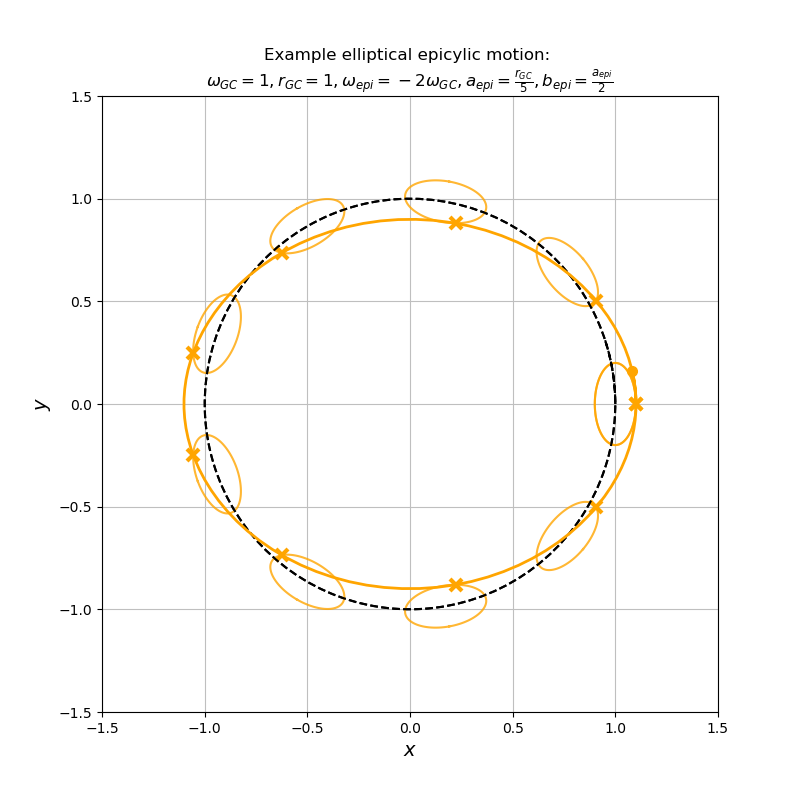

In [4]:
%reset -f
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


#Define a callback function
# Note that for matplotlib animations, the frame number increments beneath the hood

def _update_plot(i, x_GC, y_GC, line_GC, x_epi, y_epi, line_epi): 
    # i is the frame number, line is the plot object
    t=i/15 #to get better resolution, define time as some fraction of the frame number
    #gives smoother resolved curve plotted out

    #First sort out Guiding Centre:
    freqGC = 1 #positive is anticlockwise
    radiusGC = 1.0
    thetaGC = freqGC*t
    x_GC.append(radiusGC*np.cos(thetaGC))
    y_GC.append(radiusGC*np.sin(thetaGC))
    line_GC.set_data(x_GC,y_GC)

    #Next sort out the elliptical epicycle:
    freqEpi = -freqGC*2.0 # set the epicyclic frequency to be twice the Guiding Centre's (positive is anti-clockwise)
    thetaEpi = freqEpi*t
    aEpi = radiusGC/5.0 #elliptical epicycle's major axis aEpi=radiusGC/5.0
    bEpi = aEpi/2.0 #elliptical epicycle's minor axis bEpi=aEpi/2.0
    #Calculate the ellipse that is offset from the origin but parallel to y-axis
    x_epiUNROT = (bEpi*np.cos(thetaEpi))
    y_epiUNROT = (aEpi*np.sin(thetaEpi))
    #I need to offset the epicycle away from the origin (to a distance of (xGC,yGC))
    #rotate so that the ellipse major axis is tangential to GC centre (rather than parallel to y axis)
    x_epi.append( x_GC[i] + (x_epiUNROT*np.cos(thetaGC) - y_epiUNROT*np.sin(thetaGC)) )
    y_epi.append( y_GC[i] + (x_epiUNROT*np.sin(thetaGC) + y_epiUNROT*np.cos(thetaGC)) )
    
    line_epi.set_data(x_epi,y_epi)
    
    return line_GC, line_epi

fig, ax = plt.subplots(figsize=(8,8), dpi=100)

#Instantiate the x and y arrays for the guiding centre and epicyclic motions
x_GC = []
y_GC = []
x_epi = []
y_epi = []

####Add an background frame:
#First draw the guiding centre circle:
radiusGC_marker = 1.0
freq_Epi = -2.0 #edit this to match freqEpi variable in _update_plot
theta_marker = np.linspace(0, 2*np.pi, 100)
x_GC_marker = radiusGC_marker*np.cos(theta_marker)
y_GC_marker = radiusGC_marker*np.sin(theta_marker)
ax.plot(x_GC_marker,y_GC_marker,"k--") 
#Next draw the reference elliptical epicycles:
aEpi_marker=radiusGC_marker/5.0
bEpi_marker=aEpi_marker/2.0
ref_pt_x = []
ref_pt_y = []
thetaGC_refList = np.linspace(0,2*np.pi, num=10) #linspace is non-inclusive
for thetaGC_ref in thetaGC_refList: #4 ref circles in total 
    x_ref_epiUNROT = (bEpi_marker*np.cos(theta_marker))
    y_ref_epiUNROT = (aEpi_marker*np.sin(theta_marker))
    x_ref_epi =  radiusGC_marker*np.cos(thetaGC_ref) + (x_ref_epiUNROT*np.cos(thetaGC_ref) - y_ref_epiUNROT*np.sin(thetaGC_ref))
    y_ref_epi =  radiusGC_marker*np.sin(thetaGC_ref) + (x_ref_epiUNROT*np.sin(thetaGC_ref) + y_ref_epiUNROT*np.cos(thetaGC_ref)) 
    ax.plot(x_ref_epi, y_ref_epi,"-", color = "#ffa500", alpha=0.8) #plot reference epicycle ellipses
    #Next mark where on the epicycle, the current position is:
    x_ref_epiUNROT_pt = (bEpi_marker*np.cos(freq_Epi*thetaGC_ref))
    y_ref_epiUNROT_pt = (aEpi_marker*np.sin(freq_Epi*thetaGC_ref))
    ref_pt_x = (radiusGC_marker*np.cos(thetaGC_ref) + (x_ref_epiUNROT_pt*np.cos(thetaGC_ref) - y_ref_epiUNROT_pt*np.sin(thetaGC_ref)))
    ref_pt_y = (radiusGC_marker*np.sin(thetaGC_ref) + (x_ref_epiUNROT_pt*np.sin(thetaGC_ref) + y_ref_epiUNROT_pt*np.cos(thetaGC_ref))) 
    ax.plot(ref_pt_x, ref_pt_y,"x", color="#ffa500", markersize=8, markeredgewidth=3) #mark point locating where on elliptical epicycle are at that instant

#Instantiate the plot object
line_GC, line_epi = ax.plot([],[],[],[],"-")

line_GC.set_color("black")
line_GC.set_linestyle("--")
line_epi.set_color("#ffa500")
line_epi.set_linestyle("-")
line_epi.set_linewidth(2)
line_epi.set_marker("o")
line_epi.set_markersize(7)
line_epi.set_markevery([-1]) 

ax.grid(True, linestyle='-', color='0.75')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_aspect('equal')
ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$y$", fontsize=14)

ax.set_title("Example elliptical epicylic motion: \n" r"$\omega_{GC} = 1, r_{GC} = 1,  \omega_{epi} = -2\omega_{GC}, a_{epi}=\frac{r_{GC}}{5}, b_{epi}=\frac{a_{epi}}{2}$") 


#Instantiate the FuncAnimation Object, using the (fig object, callback function, Value to be passed the callback function, number of frames, call interval of the callback function)
anim = animation.FuncAnimation(fig, _update_plot, fargs = (x_GC, y_GC, line_GC,x_epi, y_epi, line_epi), 
                               frames = 100, interval = 50, repeat=False)


Playing around with different epicycle:Guiding Centre frequency ratios:

<IPython.core.display.Javascript object>


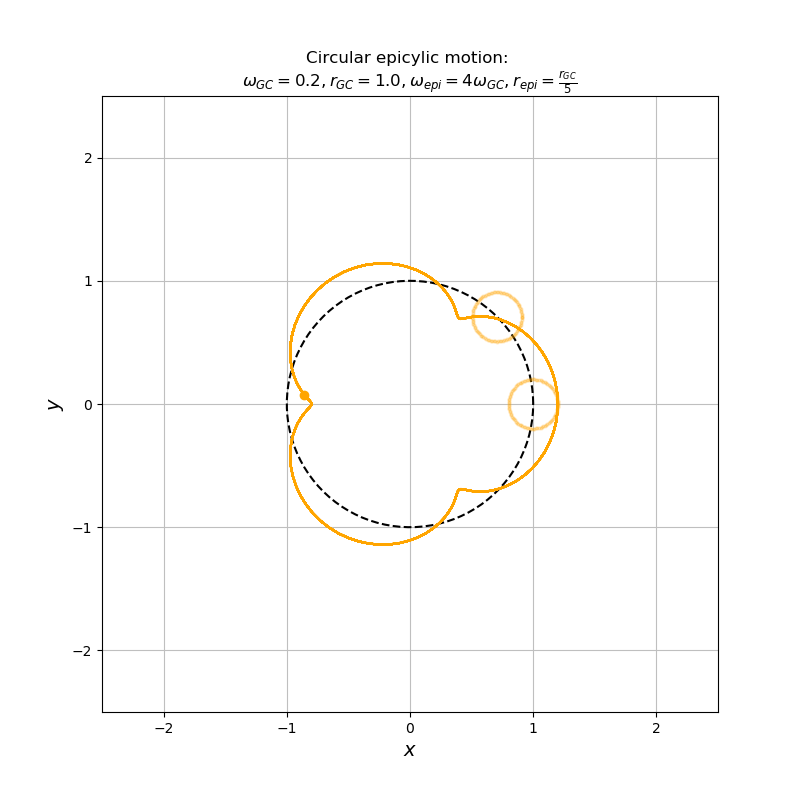

In [2]:
%reset -f
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

#Define a callback function
# Note that for matplotlib animations, the frame number (i) increments under the hood
def _update_plot(i, x_epi, y_epi, line_epi): 
    print("here")
    # i is the frame number, line is the plot object
    # Here I'm using i as a proxy for time
    t=i/4.0 #gives smoother resolution curve plotted out
    freqGC = 0.2
    radiusGC = 1.0
    x_GC = radiusGC*np.cos(freqGC*t)
    y_GC = radiusGC*np.sin(freqGC*t)
    
    freqEpi = 4*freqGC #-10
    radiusEpi=radiusGC/5
    x_epi.append(x_GC+radiusEpi*np.cos(t*freqEpi))
    y_epi.append(y_GC+radiusEpi*np.sin(t*freqEpi))
    line_epi.set_data(x_epi,y_epi)
    #return (line_epi, freqGC, freqEpi, radiusEpi)
    return line_epi

fig, ax = plt.subplots(figsize=(8,8))
#Instantiate the x and y arrays for the guiding centre and epicyclic motions
x_epi = []
y_epi = []

####Add an background frame:
radiusGC_marker = 1.0
theta_marker = np.linspace(0, 2*np.pi, 100)
x_GC_marker = radiusGC_marker*np.cos(theta_marker)
y_GC_marker = radiusGC_marker*np.sin(theta_marker)
 
radiusEpi_marker=radiusGC_marker/5
x_epi_marker1=(1+radiusEpi_marker*np.cos(theta_marker))
y_epi_marker1=(0+radiusEpi_marker*np.sin(theta_marker))
ax.plot(x_GC_marker,y_GC_marker,"k--")
ax.plot(x_epi_marker1, y_epi_marker1,"o", color="#ffa500", markersize=2,alpha=0.2)

x_epi_marker2=(1/np.sqrt(2)+radiusEpi_marker*np.cos(theta_marker))
y_epi_marker2=(1/np.sqrt(2)+radiusEpi_marker*np.sin(theta_marker))
ax.plot(x_epi_marker2, y_epi_marker2,"o", color="#ffa500", markersize=2,alpha=0.2)

line_epi, = ax.plot([],[],"-o", color="#ffa500", markevery=[-1]) #add a marker at the final element for marking position of particle

ax.grid(True, linestyle='-', color='0.75')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_aspect('equal')

ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$y$", fontsize=14)
ax.set_title("Circular epicylic motion: \n" r"$\omega_{GC} = 0.2, r_{GC} = 1.0,  \omega_{epi} = 4\omega_{GC}, r_{epi}= \frac{r_{GC}}{5} $") 

#Instantiate the FuncAnimation Object, using fig object, callback function, Value to be passed the callback function, number of frames, call interval of the callback function (in ms) and whether it repeats)
anim = animation.FuncAnimation(fig, _update_plot, fargs = (x_epi, y_epi, line_epi), 
                               frames = 126, interval = 20, repeat=True) 



## Satellite ephemerides

Early on in my PhD, I did some stuff with JPL's HORIZONS ephemerides database to visualise where moons were located in relation to rings at different times:

I forked [Michael Mommert's repo](https://github.com/mommermi/callhorizons), which provides a python interface to the JPL HORIZONS system by accessing and parsing the http website,  and [added `get_state_vectors` functionality](https://github.com/MJTMace/callhorizons/tree/get-vectors-feature-branch).

In [ ]:
# Plot out moon trajectories for a single observation date
# Note: I haven't included any try ... except ... here to catch dates for which there doesn't happen to be any data

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
import pandas as pd
import numpy as np
import callhorizons # I've specified my forked repo version (in environment.yml)
from datetime import datetime, timedelta

def calcInputParams_set_epochrange(startEpoch_str, orb_period):
    """
    Returns final datetime and stepsize for a moon's period, to be used with callHorizonsQuery_returnLists()
    Inputs: 
     - startEpoch_str = starting date and time (%Y-%b-%d %H:%M) as string
     - orb_period = orbital periods obtained earlier using HORIZONS and recorded in dict
    """
    
    orb_period = (orb_period*1.01)*24*60*60 # add a little bit of time so orbit closes and convert to seconds 
    # Convert string to datetime object
    startEpoch_dt = datetime.strptime(startEpoch_str,"%Y-%b-%d %H:%M")
    # As I want to plot out a single trajectory, I need a period's worth of data
    stopEpoch_dt = startEpoch_dt + timedelta(seconds = orb_period)             
    stepSize = orb_period/100.0 # rule-of-thumb
    # Convert to minutes and round down 
    stepSize/=60
    stepSize = np.floor(stepSize)
    # Convert to the datetime format accepted by callhorizons and convert to string:
    stopEpoch_str = str((datetime.strptime(str(stopEpoch_dt), "%Y-%m-%d %H:%M:%S.%f").strftime("%Y-%b-%d %H:%M")))
    ##stopEpoch_dt = datetime.strptime(str(stopEpoch_dt),"%Y-%m-%d %H:%M:%S.%f") # convert to string
    print("Start: ", startEpoch_str, "Stop: ", stopEpoch_str, "step: ", stepSize)        
    return(stopEpoch_str, int(stepSize))           

def callHorizonsQuery_returnLists(StartDate, StopDate, MoonID, stepSize): 
    """
    Returns the datetime, targetname and coordinates of the Moon in km
    Note the StopDate and stepSize are returned from calcInputParams_set_epochrange()
    If this python errors then useful msgs can be found by clicking on the outputted url 
    """
    print("-"*100)
    vec = callhorizons.query(targetname=MoonID,  smallbody=False)  # 618 = Pan
    vec.set_epochrange(start_epoch=StartDate, stop_epoch=StopDate, step_size=(str(stepSize)+"m") ) # ~ 1/100th of orbital period in minutes
    (vec.get_vectors(center = "500@6"), 'epochs queried') #6 = Saturn barycentre
    #print("Inside func:", vec['targetname'], vec['datetime'][0], vec['datetime_jd'][0], vec['x'][0], vec['y'][0], vec['z'][0]) # Extract the first element, ie discard all other times after StartDate
    return(vec['datetime'], vec['targetname'], vec['x'], vec['y'] ) #array 

# Initialise the variables :
## Orbital period stuff (obtained from callhorizons):
orb_periods_dict = {"Pan":0.5750, "Daphnis":np.NaN, "Atlas":0.6019, "Prometheus":0.612986, "Pandora":0.628804,
             "Epimetheus": 0.694590, "Janus":0.694590, "Aegaeon": np.NaN, "Mimas":0.9424218, "Methone":np.NaN,
             "Anthe":np.NaN, "Pallene":np.NaN, "Enceladus":1.370218, "Tethys":1.888, "Telesto":1.887802,
             "Calypso":1.887802, "Polydeuces":np.NaN, "Dione":2.736915, "Helene":2.736915, "Rhea":4.518}#,
             #"Titan":15.945421, "Hyperion": 21.276609} #, "Iapetus":79.33}#, "Phoebe":550.31}# in days

# Use the data from NASA's Saturnian Satellite Fact Sheet to fill in the NaNs:
orb_periods_dict["Daphnis"] = 0.594 # in days
orb_periods_dict["Aegaeon"] = 0.8081
orb_periods_dict["Methone"] = 1.01
orb_periods_dict["Anthe"] = 1.04
orb_periods_dict["Pallene"] = 1.14
orb_periods_dict["Polydeuces"] = 2.74

# NAIF body IDs:
moon_ID_dict = {"Pan":"618", "Daphnis":"635", "Atlas":"615", "Prometheus":"616", "Pandora":"617",
             "Epimetheus": "611", "Janus":"610", "Aegaeon": "653", "Mimas":"601", "Methone":"632",
             "Anthe":"649", "Pallene":"633", "Enceladus":"602", "Tethys":"603", "Telesto":"613",
             "Calypso":"614", "Polydeuces":"634", "Dione":"604", "Helene":"612", "Rhea":"605"}#,
             #"Titan":"606", "Hyperion": "607"}#, "Iapetus":"608"}#, "Phoebe":"609"}

start_date = "1994-Dec-01 00:00" # E.g. recorded date for observation of spokes (HST, McGhee 1998)

## Setup the plotting figure :
fig, ax = plt.subplots(figsize=(15,15)) #OOP approach -> store figure & axis references to the newly created subplots instance
# Draw on Saturn:
R_S = 60300 # Saturn's radius in km
saturn_circ = Circle((0,0), radius=1, color="#edcb23")
ax.add_artist(saturn_circ)
# Draw on main rings (ref: https://en.wikipedia.org/wiki/Rings_of_Saturn#Subdivisions_and_structures_within_the_rings)
# Wedge: If width is given, then a partial wedge is drawn from inner radius r - width to outer radius r.
Aring = Wedge(center=(0, 0),r=136775/R_S, theta1=0, theta2=360, width=14600/R_S, color="#cbced2", alpha=0.5) # A ring spans 122,170 – 136,775 km
Bring = Wedge(center=(0, 0),r=117580/R_S, theta1=0, theta2=360, width=25500/R_S, color="#e1e3e5", alpha=0.5) # B ring spans 92,000   –  117,580 km
Cring = Wedge(center=(0, 0),r=92000/R_S, theta1=0, theta2=360, width=17500/R_S, color="#b5b9bf", alpha=0.5) # C ring spans 74,658 – 92,000 km
Dring = Wedge(center=(0, 0),r=74510/R_S, theta1=0, theta2=360, width=7500/R_S, color="#909498", alpha=0.5) # D ring spands 66,900   –  74,510 km

ax.add_artist(Aring)
ax.add_artist(Bring)
ax.add_artist(Cring)
ax.add_artist(Dring)

# Mark on radial position where Keplerian orbital period is 1 day
#kep_oneDay_R = ( ((6.67e-11*5.68e26)*(24*60*60)**2)/(4*np.pi**2) )**(1.0/3.0) #in metres
#kepPeriodOneDay = Circle((0,0), radius=kep_oneDay_R/(R_S*1000), color="k", fill=None, linestyle="--", lw = 2)
#ax.add_artist(kepPeriodOneDay)

synch_R = 1.86 #synchronous orbit (where spin frequency = keplerian orbital frequency)
synchOrbit = Circle((0,0), radius=synch_R, color="k", fill=None, linestyle=":", lw = 1.5, alpha=0.8)
ax.add_artist(synchOrbit)

# Sort out axes' labels
ax.set_xlabel("$x$ / $R_S$", fontsize=18)
ax.set_ylabel("$y$ / $R_S$", fontsize=18)
# Set axis limits based on outermost moon's sma
ax.set_xlim(-8, 8) 
ax.set_ylim(-8, 8)

# Loop through moons:
# Could be made more efficient by 
for moonkey in moon_ID_dict:
    # calculate the input parameters for the .set_epochrange call in callHorizonsQuery_returnLists()
    (stop_date, step) = calcInputParams_set_epochrange(start_date, orb_periods_dict[moonkey])
    moon_id = moon_ID_dict[moonkey]
    # call the function for each row and unpack into appropriately named new columns
    (datetime_list, targetname_list, xCoord_list, yCoord_list) = callHorizonsQuery_returnLists(start_date, stop_date, moon_id, step) 
    # Draw on the orbital trajectory:
    line=ax.plot(xCoord_list/R_S, yCoord_list/R_S,"-", label=moonkey)
    # Label orbits:
    ax.text(x=xCoord_list[0]/R_S ,y=yCoord_list[0]/R_S , s=moonkey, color = line[0].get_color(), fontsize=14)
    # Next use circular marker to show moon's position at the time (ie start_date) specified on the plot's title
    ax.plot(xCoord_list[0]/R_S,yCoord_list[0]/R_S, "o", color = line[0].get_color())

ax.set_aspect('equal')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.title((datetime.strptime(start_date,"%Y-%b-%d %H:%M")).date(), fontsize=18)  

plt.show()